In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest26d'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))

In [5]:
def preprocess_image(image):
    image[:,:,0]=np.clip(image[:,:,0],a_min=0,a_max=0.66)*1.5
    return image

class ContrailsDataset(Dataset):
    def __init__(self, df, transform, mode='train'):
        self.df = df
        self.transform = A.Compose(transform)
        self.mode = mode

    def __getitem__(self, index):
        row = self.df.iloc[index]
        path = row.path
        record_id = row.record_id
        npy = fastnumpyio.load(str(path)).astype("float32")

        if self.mode == 'train':
            image = npy[..., :-1]
            label = npy[..., -1]
            image = preprocess_image(image)
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']
            label = np.expand_dims(label, 0)
            image = torch.tensor(image)
            label = torch.tensor(label)
            return image.float(), label.float()

        if self.mode == 'test':
            image = npy
            data = self.transform(image=image)
            image = data['image']
            image = torch.tensor(image)
            return image.float(), record_id

    def __len__(self):
        return len(self.df)


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



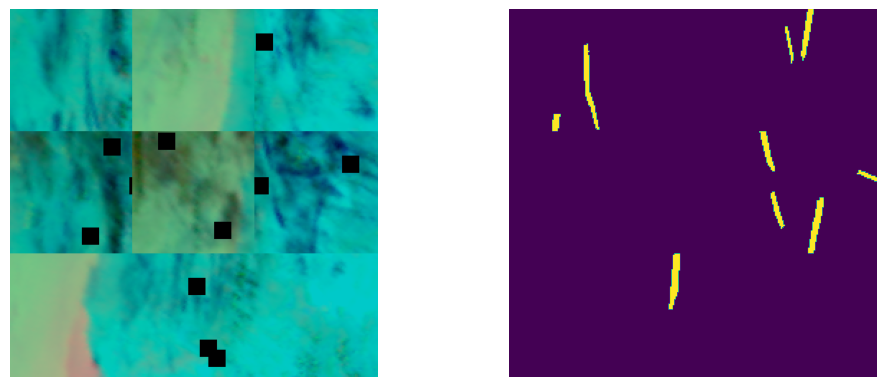

In [6]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(112, dataset_train)

# Model

In [7]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest26d


In [8]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [9]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        epoch_best=epoch
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
    
    if epoch-epoch_best>=CFG.epochs_patience:
        print('Early Stopping')
        break
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 7.79GB  LR : 1.00E-04  Loss: 0.8055: 100%|██████████| 642/642 
Val Loss: 0.6435: 100%|██████████| 58/58 [00:03<00:00, 15.85it/s]               


FBeta : 0.5227	thresh : 0.59	SAVED MODEL



Epoch 1/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.5335: 100%|██████████| 642/642 
Val Loss: 0.5709: 100%|██████████| 58/58 [00:03<00:00, 14.56it/s]               


FBeta : 0.4791	thresh : 0.07



Epoch 2/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4968: 100%|██████████| 642/642 
Val Loss: 0.5152: 100%|██████████| 58/58 [00:04<00:00, 14.44it/s]               


FBeta : 0.5273	thresh : 0.99	SAVED MODEL



Epoch 3/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4797: 100%|██████████| 642/642 
Val Loss: 0.5153: 100%|██████████| 58/58 [00:03<00:00, 14.60it/s]               


FBeta : 0.5356	thresh : 0.01	SAVED MODEL



Epoch 4/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4718: 100%|██████████| 642/642 
Val Loss: 0.4798: 100%|██████████| 58/58 [00:03<00:00, 14.92it/s]               


FBeta : 0.5602	thresh : 0.97	SAVED MODEL



Epoch 5/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4674: 100%|██████████| 642/642 
Val Loss: 0.4761: 100%|██████████| 58/58 [00:03<00:00, 14.89it/s]               


FBeta : 0.5569	thresh : 0.07



Epoch 6/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4629: 100%|██████████| 642/642 
Val Loss: 0.4965: 100%|██████████| 58/58 [00:03<00:00, 14.94it/s]               


FBeta : 0.5428	thresh : 0.35



Epoch 7/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4595: 100%|██████████| 642/642 
Val Loss: 0.4717: 100%|██████████| 58/58 [00:03<00:00, 14.93it/s]               


FBeta : 0.5600	thresh : 0.97



Epoch 8/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4548: 100%|██████████| 642/642 
Val Loss: 0.4682: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.5627	thresh : 0.09	SAVED MODEL



Epoch 9/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4553: 100%|██████████| 642/642 
Val Loss: 0.4782: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.5637	thresh : 0.01	SAVED MODEL



Epoch 10/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4488: 100%|██████████| 642/642
Val Loss: 0.4576: 100%|██████████| 58/58 [00:03<00:00, 14.86it/s]               


FBeta : 0.5768	thresh : 0.09	SAVED MODEL



Epoch 11/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4480: 100%|██████████| 642/642
Val Loss: 0.4440: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.5865	thresh : 0.29	SAVED MODEL



Epoch 12/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4429: 100%|██████████| 642/642
Val Loss: 0.4655: 100%|██████████| 58/58 [00:03<00:00, 14.77it/s]               


FBeta : 0.5658	thresh : 0.47



Epoch 13/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4404: 100%|██████████| 642/642
Val Loss: 0.4430: 100%|██████████| 58/58 [00:03<00:00, 14.87it/s]               


FBeta : 0.5834	thresh : 0.05



Epoch 14/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4426: 100%|██████████| 642/642
Val Loss: 0.4464: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.5826	thresh : 0.77



Epoch 15/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4366: 100%|██████████| 642/642
Val Loss: 0.4382: 100%|██████████| 58/58 [00:03<00:00, 14.79it/s]               


FBeta : 0.5884	thresh : 0.11	SAVED MODEL



Epoch 16/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4364: 100%|██████████| 642/642
Val Loss: 0.4501: 100%|██████████| 58/58 [00:03<00:00, 15.13it/s]               


FBeta : 0.5857	thresh : 0.01



Epoch 17/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4359: 100%|██████████| 642/642
Val Loss: 0.4341: 100%|██████████| 58/58 [00:03<00:00, 14.81it/s]               


FBeta : 0.5980	thresh : 0.97	SAVED MODEL



Epoch 18/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4340: 100%|██████████| 642/642
Val Loss: 0.4394: 100%|██████████| 58/58 [00:03<00:00, 15.28it/s]               


FBeta : 0.5921	thresh : 0.99



Epoch 19/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4306: 100%|██████████| 642/642
Val Loss: 0.4423: 100%|██████████| 58/58 [00:03<00:00, 15.15it/s]               


FBeta : 0.5910	thresh : 0.37



Epoch 20/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4331: 100%|██████████| 642/642
Val Loss: 0.4330: 100%|██████████| 58/58 [00:03<00:00, 15.20it/s]               


FBeta : 0.5969	thresh : 0.03



Epoch 21/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4303: 100%|██████████| 642/642
Val Loss: 0.4234: 100%|██████████| 58/58 [00:03<00:00, 15.19it/s]               


FBeta : 0.6054	thresh : 0.99	SAVED MODEL



Epoch 22/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4267: 100%|██████████| 642/642
Val Loss: 0.4318: 100%|██████████| 58/58 [00:03<00:00, 14.95it/s]               


FBeta : 0.5995	thresh : 0.73



Epoch 23/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4254: 100%|██████████| 642/642
Val Loss: 0.4367: 100%|██████████| 58/58 [00:03<00:00, 15.07it/s]               


FBeta : 0.5925	thresh : 0.55



Epoch 24/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4253: 100%|██████████| 642/642
Val Loss: 0.4152: 100%|██████████| 58/58 [00:03<00:00, 15.09it/s]               


FBeta : 0.6101	thresh : 0.51	SAVED MODEL



Epoch 25/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4246: 100%|██████████| 642/642
Val Loss: 0.4336: 100%|██████████| 58/58 [00:03<00:00, 15.24it/s]               


FBeta : 0.5909	thresh : 0.15



Epoch 26/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4203: 100%|██████████| 642/642
Val Loss: 0.4390: 100%|██████████| 58/58 [00:03<00:00, 15.01it/s]               


FBeta : 0.5922	thresh : 0.99



Epoch 27/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4233: 100%|██████████| 642/642
Val Loss: 0.4290: 100%|██████████| 58/58 [00:03<00:00, 15.15it/s]               


FBeta : 0.5982	thresh : 0.79



Epoch 28/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4209: 100%|██████████| 642/642
Val Loss: 0.4229: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6079	thresh : 0.01



Epoch 29/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4215: 100%|██████████| 642/642
Val Loss: 0.4255: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.6055	thresh : 0.35



Epoch 30/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4189: 100%|██████████| 642/642
Val Loss: 0.4215: 100%|██████████| 58/58 [00:03<00:00, 15.14it/s]               


FBeta : 0.6057	thresh : 0.99



Epoch 31/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4145: 100%|██████████| 642/642
Val Loss: 0.4204: 100%|██████████| 58/58 [00:03<00:00, 15.23it/s]               


FBeta : 0.6110	thresh : 0.07	SAVED MODEL



Epoch 32/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4168: 100%|██████████| 642/642
Val Loss: 0.4080: 100%|██████████| 58/58 [00:03<00:00, 15.27it/s]               


FBeta : 0.6177	thresh : 0.99	SAVED MODEL



Epoch 33/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4140: 100%|██████████| 642/642
Val Loss: 0.4070: 100%|██████████| 58/58 [00:03<00:00, 15.26it/s]               


FBeta : 0.6213	thresh : 0.99	SAVED MODEL



Epoch 34/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4148: 100%|██████████| 642/642
Val Loss: 0.4154: 100%|██████████| 58/58 [00:03<00:00, 15.25it/s]               


FBeta : 0.6136	thresh : 0.99



Epoch 35/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4127: 100%|██████████| 642/642
Val Loss: 0.4241: 100%|██████████| 58/58 [00:03<00:00, 15.15it/s]               


FBeta : 0.6066	thresh : 0.99



Epoch 36/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4118: 100%|██████████| 642/642
Val Loss: 0.4115: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6156	thresh : 0.11



Epoch 37/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4118: 100%|██████████| 642/642
Val Loss: 0.4092: 100%|██████████| 58/58 [00:04<00:00, 14.24it/s]               


FBeta : 0.6200	thresh : 0.01



Epoch 38/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4125: 100%|██████████| 642/642
Val Loss: 0.4084: 100%|██████████| 58/58 [00:03<00:00, 15.27it/s]               


FBeta : 0.6187	thresh : 0.99



Epoch 39/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4080: 100%|██████████| 642/642
Val Loss: 0.4122: 100%|██████████| 58/58 [00:03<00:00, 15.19it/s]               


FBeta : 0.6144	thresh : 0.45



Epoch 40/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4061: 100%|██████████| 642/642
Val Loss: 0.4129: 100%|██████████| 58/58 [00:03<00:00, 15.04it/s]               


FBeta : 0.6161	thresh : 0.07



Epoch 41/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4049: 100%|██████████| 642/642
Val Loss: 0.4126: 100%|██████████| 58/58 [00:03<00:00, 15.17it/s]               


FBeta : 0.6146	thresh : 0.23



Epoch 42/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4063: 100%|██████████| 642/642
Val Loss: 0.4077: 100%|██████████| 58/58 [00:03<00:00, 15.24it/s]               


FBeta : 0.6220	thresh : 0.01	SAVED MODEL



Epoch 43/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4057: 100%|██████████| 642/642
Val Loss: 0.4008: 100%|██████████| 58/58 [00:03<00:00, 15.12it/s]               


FBeta : 0.6248	thresh : 0.05	SAVED MODEL



Epoch 44/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4033: 100%|██████████| 642/642
Val Loss: 0.4077: 100%|██████████| 58/58 [00:03<00:00, 15.21it/s]               


FBeta : 0.6225	thresh : 0.97



Epoch 45/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4054: 100%|██████████| 642/642
Val Loss: 0.3966: 100%|██████████| 58/58 [00:03<00:00, 15.16it/s]               


FBeta : 0.6314	thresh : 0.03	SAVED MODEL



Epoch 46/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4016: 100%|██████████| 642/642
Val Loss: 0.3966: 100%|██████████| 58/58 [00:03<00:00, 15.38it/s]               


FBeta : 0.6300	thresh : 0.87



Epoch 47/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3984: 100%|██████████| 642/642
Val Loss: 0.3968: 100%|██████████| 58/58 [00:03<00:00, 15.17it/s]               


FBeta : 0.6314	thresh : 0.81	SAVED MODEL



Epoch 48/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3992: 100%|██████████| 642/642
Val Loss: 0.3909: 100%|██████████| 58/58 [00:03<00:00, 15.34it/s]               


FBeta : 0.6318	thresh : 0.67	SAVED MODEL



Epoch 49/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3980: 100%|██████████| 642/642
Val Loss: 0.3997: 100%|██████████| 58/58 [00:03<00:00, 15.24it/s]               


FBeta : 0.6255	thresh : 0.01



Epoch 50/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3983: 100%|██████████| 642/642
Val Loss: 0.3934: 100%|██████████| 58/58 [00:03<00:00, 15.20it/s]               


FBeta : 0.6310	thresh : 0.59



Epoch 51/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3986: 100%|██████████| 642/642
Val Loss: 0.3980: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.6276	thresh : 0.13



Epoch 52/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3942: 100%|██████████| 642/642
Val Loss: 0.4003: 100%|██████████| 58/58 [00:03<00:00, 15.34it/s]               


FBeta : 0.6278	thresh : 0.03



Epoch 53/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3941: 100%|██████████| 642/642
Val Loss: 0.3943: 100%|██████████| 58/58 [00:03<00:00, 15.25it/s]               


FBeta : 0.6320	thresh : 0.47	SAVED MODEL



Epoch 54/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3955: 100%|██████████| 642/642
Val Loss: 0.3865: 100%|██████████| 58/58 [00:03<00:00, 15.23it/s]               


FBeta : 0.6373	thresh : 0.97	SAVED MODEL



Epoch 55/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3935: 100%|██████████| 642/642
Val Loss: 0.3833: 100%|██████████| 58/58 [00:03<00:00, 15.20it/s]               


FBeta : 0.6396	thresh : 0.85	SAVED MODEL



Epoch 56/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3909: 100%|██████████| 642/642
Val Loss: 0.3851: 100%|██████████| 58/58 [00:03<00:00, 15.33it/s]               


FBeta : 0.6392	thresh : 0.67



Epoch 57/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3893: 100%|██████████| 642/642
Val Loss: 0.3843: 100%|██████████| 58/58 [00:03<00:00, 15.22it/s]               


FBeta : 0.6391	thresh : 0.89



Epoch 58/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3893: 100%|██████████| 642/642
Val Loss: 0.3892: 100%|██████████| 58/58 [00:03<00:00, 15.22it/s]               


FBeta : 0.6336	thresh : 0.05



Epoch 59/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3877: 100%|██████████| 642/642
Val Loss: 0.3858: 100%|██████████| 58/58 [00:03<00:00, 15.26it/s]               


FBeta : 0.6380	thresh : 0.95



Epoch 60/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3883: 100%|██████████| 642/642
Val Loss: 0.3862: 100%|██████████| 58/58 [00:03<00:00, 15.28it/s]               


FBeta : 0.6375	thresh : 0.05



Epoch 61/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3869: 100%|██████████| 642/642
Val Loss: 0.3840: 100%|██████████| 58/58 [00:03<00:00, 14.91it/s]               


FBeta : 0.6407	thresh : 0.89	SAVED MODEL



Epoch 62/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3843: 100%|██████████| 642/642
Val Loss: 0.3945: 100%|██████████| 58/58 [00:03<00:00, 14.71it/s]               


FBeta : 0.6316	thresh : 0.49



Epoch 63/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3835: 100%|██████████| 642/642
Val Loss: 0.3820: 100%|██████████| 58/58 [00:03<00:00, 14.95it/s]               


FBeta : 0.6428	thresh : 0.11	SAVED MODEL



Epoch 64/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3828: 100%|██████████| 642/642
Val Loss: 0.3833: 100%|██████████| 58/58 [00:03<00:00, 14.96it/s]               


FBeta : 0.6419	thresh : 0.03



Epoch 65/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3829: 100%|██████████| 642/642
Val Loss: 0.3798: 100%|██████████| 58/58 [00:03<00:00, 14.86it/s]               


FBeta : 0.6420	thresh : 0.79



Epoch 66/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3821: 100%|██████████| 642/642
Val Loss: 0.3898: 100%|██████████| 58/58 [00:03<00:00, 14.85it/s]               


FBeta : 0.6344	thresh : 0.01



Epoch 67/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3809: 100%|██████████| 642/642
Val Loss: 0.3857: 100%|██████████| 58/58 [00:03<00:00, 14.82it/s]               


FBeta : 0.6376	thresh : 0.03



Epoch 68/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3768: 100%|██████████| 642/642
Val Loss: 0.3825: 100%|██████████| 58/58 [00:03<00:00, 14.99it/s]               


FBeta : 0.6416	thresh : 0.01



Epoch 69/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3780: 100%|██████████| 642/642
Val Loss: 0.3863: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6393	thresh : 0.05



Epoch 70/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3786: 100%|██████████| 642/642
Val Loss: 0.3811: 100%|██████████| 58/58 [00:03<00:00, 15.06it/s]               


FBeta : 0.6420	thresh : 0.27



Epoch 71/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3764: 100%|██████████| 642/642
Val Loss: 0.3801: 100%|██████████| 58/58 [00:03<00:00, 15.20it/s]               


FBeta : 0.6425	thresh : 0.11



Epoch 72/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3773: 100%|██████████| 642/642
Val Loss: 0.3802: 100%|██████████| 58/58 [00:03<00:00, 15.15it/s]               


FBeta : 0.6441	thresh : 0.03	SAVED MODEL



Epoch 73/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3750: 100%|██████████| 642/642
Val Loss: 0.3813: 100%|██████████| 58/58 [00:03<00:00, 15.21it/s]               


FBeta : 0.6439	thresh : 0.49



Epoch 74/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3750: 100%|██████████| 642/642
Val Loss: 0.3841: 100%|██████████| 58/58 [00:03<00:00, 15.11it/s]               


FBeta : 0.6393	thresh : 0.13



Epoch 75/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3739: 100%|██████████| 642/642
Val Loss: 0.3787: 100%|██████████| 58/58 [00:03<00:00, 15.23it/s]               


FBeta : 0.6443	thresh : 0.85	SAVED MODEL



Epoch 76/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3765: 100%|██████████| 642/642
Val Loss: 0.3792: 100%|██████████| 58/58 [00:03<00:00, 15.23it/s]               


FBeta : 0.6441	thresh : 0.25



Epoch 77/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3729: 100%|██████████| 642/642
Val Loss: 0.3756: 100%|██████████| 58/58 [00:03<00:00, 15.24it/s]               


FBeta : 0.6471	thresh : 0.55	SAVED MODEL



Epoch 78/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3726: 100%|██████████| 642/642
Val Loss: 0.3751: 100%|██████████| 58/58 [00:03<00:00, 15.15it/s]               


FBeta : 0.6477	thresh : 0.17	SAVED MODEL



Epoch 79/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3731: 100%|██████████| 642/642
Val Loss: 0.3760: 100%|██████████| 58/58 [00:03<00:00, 15.27it/s]               


FBeta : 0.6476	thresh : 0.07



Epoch 80/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3717: 100%|██████████| 642/642
Val Loss: 0.3758: 100%|██████████| 58/58 [00:03<00:00, 15.16it/s]               


FBeta : 0.6473	thresh : 0.11



Epoch 81/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3708: 100%|██████████| 642/642
Val Loss: 0.3745: 100%|██████████| 58/58 [00:03<00:00, 15.14it/s]               


FBeta : 0.6482	thresh : 0.31	SAVED MODEL



Epoch 82/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3717: 100%|██████████| 642/642
Val Loss: 0.3744: 100%|██████████| 58/58 [00:03<00:00, 15.16it/s]               


FBeta : 0.6489	thresh : 0.45	SAVED MODEL



Epoch 83/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3712: 100%|██████████| 642/642
Val Loss: 0.3765: 100%|██████████| 58/58 [00:03<00:00, 15.12it/s]               


FBeta : 0.6479	thresh : 0.69



Epoch 84/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3709: 100%|██████████| 642/642
Val Loss: 0.3765: 100%|██████████| 58/58 [00:03<00:00, 15.18it/s]               


FBeta : 0.6475	thresh : 0.19



Epoch 85/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3714: 100%|██████████| 642/642
Val Loss: 0.3755: 100%|██████████| 58/58 [00:03<00:00, 14.99it/s]               


FBeta : 0.6486	thresh : 0.09



Epoch 86/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3706: 100%|██████████| 642/642
Val Loss: 0.3766: 100%|██████████| 58/58 [00:03<00:00, 15.17it/s]               


FBeta : 0.6476	thresh : 0.25



Epoch 87/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3700: 100%|██████████| 642/642
Val Loss: 0.3760: 100%|██████████| 58/58 [00:03<00:00, 15.22it/s]               


FBeta : 0.6478	thresh : 0.51



Epoch 88/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3717: 100%|██████████| 642/642
Val Loss: 0.3763: 100%|██████████| 58/58 [00:03<00:00, 15.11it/s]               


FBeta : 0.6479	thresh : 0.59



Epoch 89/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3714: 100%|██████████| 642/642
Val Loss: 0.3757: 100%|██████████| 58/58 [00:03<00:00, 15.08it/s]               


FBeta : 0.6483	thresh : 0.73

{"status":200,"message":"ok"}

In [10]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest26d
0.6489


In [11]:
# for i, (images, masks) in enumerate(dataloader_valid):
#     if i!=1: continue
    
#     images, masks = images.cuda(), masks.cuda()
#     with torch.no_grad():
#         preds = model(images)
#         preds = torch.sigmoid(preds)
#     images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
#     for num in range(CFG.valid_batch_size):
#         fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
#         axes = axes.flatten()
#         axes[0].imshow(images[num].permute(1,2,0))
#         axes[0].axis('off')
#         axes[0].set_title('Image')
#         axes[1].imshow(masks[num].permute(1,2,0))
#         axes[1].axis('off')
#         axes[1].set_title('Ground Truth')
#         axes[2].imshow(preds[num].permute(1,2,0))
#         axes[2].axis('off')
#         axes[2].set_title('pred')
#         axes[3].imshow((preds[num]>thresh).permute(1,2,0))
#         axes[3].axis('off')
#         axes[3].set_title('pred_thresh')
#     break